# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. Challenges might be sampling convergence due to high energy barriers or entropy differences. 


To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states. 



Here we calculate the Gibbs Free Energy.

$A_x = V_x - T_x  S_x = -\beta ln(Z_x) $



Get to stat therm:

Or we can use the statistical approach:

$G_x = -\frac{1}{\beta}  ln(e^{-\beta H_x})$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta G_{ij} = G_j - G_i = -\beta ln(Z_i/Z_j)$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * TI
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


References:
    - a good page to learn about free energies: http://www.alchemistry.org 
   

In [30]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzigReweighting, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.integrator.stochastic import metropolisMonteCarloIntegrator, langevinIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import static_sim_plots

from ensembler.conditions.box_conditions import periodicBoundaryCondition


import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [23]:
simulation_steps_total_per_approach = 10000
space_range = [-10, 10]
rand=0.1
gamma=100


## Setting up a System
We are now going to Setup a system, for the Free Energy Calculations. For this Notebook, we want to keep it simple. Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us.



<IPython.core.display.Javascript object>


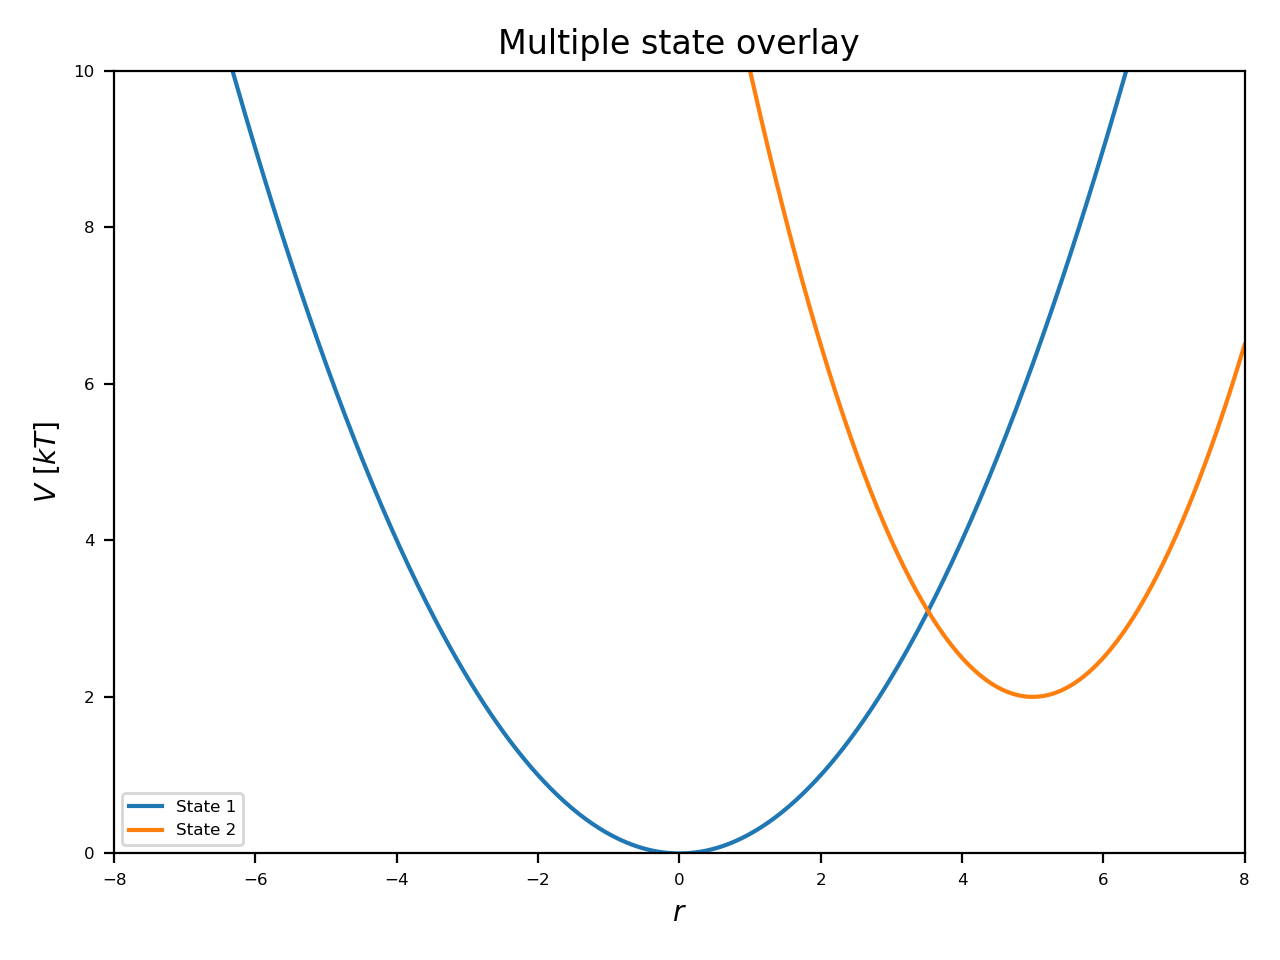

In [48]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 =0.5

entropic_difference = k2 = 1
potential_difference = yoff2 = 2#1
phase_space_distance = xoff2 = 5

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

%matplotlib notebook
fig, _ = multiState_overlays([h1,h2])
fig.tight_layout()
#fig.savefig("2state_systems.png")


## Analyctical Solution
The Analytical solution for our problem can be calculated as follows: 


Check Eq

Gibbs Energy:   
$ A_x = V_x - T_x  S_x $

For a harmonic Oscillator the entropy term can be formulated as:

$A_x = V_x - \frac{1}{\beta} log(\sqrt{\frac{2 \pi}{k_X \beta}})$



The final free energy difference is:

$\Delta G_{ij} = G_j - G_i$ 


In [32]:
#Analytical Solution
beta = 1 # beta is in kT

G_1 = yoff1 -(1/beta) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
G_2 = yoff2 -(1/beta) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dG_expected = G_2-G_1

print("expected dG: ", dG_expected)


expected dG:  2.3465735902799727


## Free Energy Pertubation Method with BAR/Zwanzig
In this Category of methods, each of the endstates will be simulated. Afterwards, the trajectories will be evaluated again with the opposite state and afterwards the free energy will be evaluated.

### Sampling
Now we build first the two systems and run the simulations.


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001F3D8A14E08>]}



{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001F3D8CFB988>]}


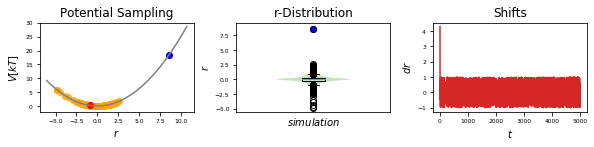

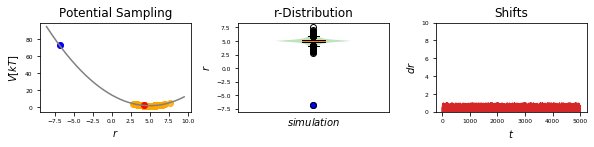

In [5]:
#Simulate the two states:
steps = simulation_steps_total_per_approach//2
equilibration_steps = 100

##Build Systems
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
integrator2 = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

system1 = system(potential=h1, integrator=integrator)
system2 = system(potential=h2, integrator=integrator2)

##Simulate:
system1.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = system1.getTrajectory()
_ = static_sim_plots(system1)

system2.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = system2.getTrajectory()

#visualize
_ = static_sim_plots(system2)
plt.ylim([0,10])
pass

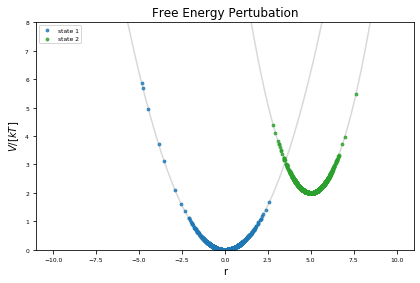

In [6]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system1.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="state 1",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="grey", zorder=-10,alpha=0.3)
ene = system2.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="state 2",s=8)
ax[0].set_ylim([0,8])

ax[0].set_xlabel("r")
ax[0].set_xlabel("r")

ax[0].set_ylabel("$V/[kT]$")
#ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("Free Energy Pertubation")
#ax[0].set_title("State 2")

fig.savefig("freeEnergyPertubation.png")

### Analysis
#### Zwanzig Equation

In [7]:
V1=state1_traj.totEnergy[equilibration_steps:]
V2=state2_traj.totEnergy[equilibration_steps:]

zwanz = zwanzigEquation(kT=True)
dF_zwanzig = zwanz.calculate(Vi=V1, Vj=V2)

print("Expected Result: ", dG_expected)
print("Zwanzig Result: ", dF_zwanzig)
print()
print("Difference:", dF_zwanzig - dG_expected)


Expected Result:  2.3465735902799727
Zwanzig Result:  2.0193667789746836

Difference: -0.32720681130528906


#### Bennet Acceptance Ratio (BAR)

In [8]:
#Sampling l1
V11=h1.ene(state1_traj.position)
V21=h2.ene(state1_traj.position)

#Sampling l2
V12=h1.ene(state2_traj.position)
V22=h2.ene(state2_traj.position)

bar = bennetAcceptanceRatio(kT=True)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22)

print()
print("Expected Result: ", dG_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dG_expected)


Iteration: 0	dF: 3.544054438881925218636501447		tDiff:  3.544054438881925218636501447 convRad 1e-05 	newC 3.544054438881925218636501447 

Iteration: 1	dF: 3.102474799138125381022478020		tDiff:  0.441579639743799837614023427 convRad 1e-05 	newC 3.102474799138125381022478020 

Iteration: 2	dF: 3.172368896483448331851705674		tDiff:  0.069894097345322950829227654 convRad 1e-05 	newC 3.172368896483448331851705674 

Iteration: 3	dF: 3.162341640064072005865066668		tDiff:  0.010027256419376325986639006 convRad 1e-05 	newC 3.162341640064072005865066668 

Iteration: 4	dF: 3.163800790290534118035966989		tDiff:  0.001459150226462112170900321 convRad 1e-05 	newC 3.163800790290534118035966989 

Iteration: 5	dF: 3.163588896795846851737876943		tDiff:  0.000211893494687266298090046 convRad 1e-05 	newC 3.163588896795846851737876943 

Iteration: 6	dF: 3.163619676607119701377414171		tDiff:  0.000030779811272849639537228 convRad 1e-05 	newC 3.163619676607119701377414171 

Iteration: 7	dF: 3.163615205703645

# Linear Coupling Method - Thermodynamic Integration (TI)

## Sampling

Text(0.5, 1.0, 'Sampled Potentials')

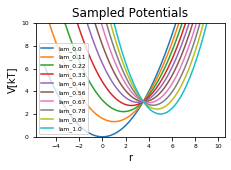

In [26]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)
for lam in lambda_windows:
    V_perturbed.set_lam(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()
plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [27]:
steps = simulation_steps_total_per_approach//lambda_points
equilibration_steps = 30

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
perturbed_system = perturbedSystem(potential=V_perturbed, integrator=integrator)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lam(lam)
    perturbed_system.simulate(steps, withdrawTraj=True, initSystem=True)
    system_trajs.update({lam: perturbed_system.trajectory})


### Analysis

#### Exponential Formula

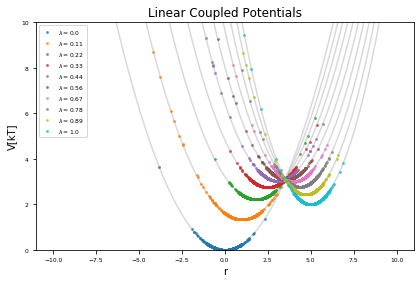

In [35]:
from ensembler import visualisation

#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [0, 10]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))
for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lam(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    
    axes[0].plot(positions,ene, c="grey", zorder=-10,alpha=0.3)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

#axes[1].violinplot(logExp, positions=all_lams, showextrema=False, widths=[0.1 for x in range(len(all_lams))])
#axes[1].boxplot(logExp,  positions=np.round(all_lams, 2), widths=[0.1 for x in range(len(all_lams))])

axes[0].legend()
axes[0].set_ylim(y_range)
axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Linear Coupled Potentials")

#axes[1].set_xlim([-0.2,1.2])
#axes[1].set_ylim([-1,30])

fig.savefig("linear_coupled.png")

9 9


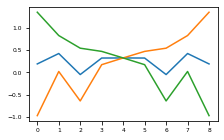

(-0.22829177387167077, -0.2282917738716712, -0.2282917738716712)

In [47]:
dA_i_dw = []
dA_i_fw = []
dA_i_bw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.totPotEnergy
    Vj_fw = trajJ.totPotEnergy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

rall_lams = list(reversed(all_lams))
for lamI, lamJ in zip(rall_lams[1:], rall_lams[:-1]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]
    
    Vi_bw = trajI.totPotEnergy    
    Vj_bw = trajJ.totPotEnergy
    
    dF_zwanzig_bw = zwanz.calculate(Vi=Vi_bw, Vj=Vj_bw)
    dA_i_bw.append(dF_zwanzig_bw)
    
for fe_fw, fe_bw in zip(dA_i_fw, dA_i_bw):
    dF_zwanzig = (fe_fw+fe_bw)/2
    dA_i_dw.append(dF_zwanzig)
    
print(len(dA_i_fw), len(dA_i_bw))
plt.plot(dA_i_dw)
plt.plot(dA_i_bw)
plt.plot(dA_i_fw)
plt.show()

A_fw = sum(dA_i_fw)
A_rev = sum(dA_i_bw)
A_dw = sum(dA_i_dw)

A_fw-dG_expected, A_rev-dG_expected, A_dw-dG_expected

#### Thermodynamic Integration

Text(0.5, 0.98, 'Lambda points')

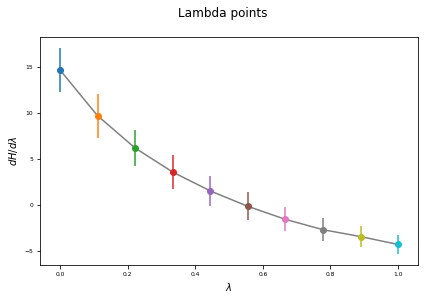

In [41]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("Lambda points")


In [42]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 


In [45]:
dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  2.3465735902799727
trapez Rule Result:  2.0877974530967385 +- 1.6361769044985488

Difference: -0.2587761371832342


In [44]:
# or kepschler Weinfass method @gerhard
dF_simpson = integrate.simps(x=lam, y=means)
dF_err = integrate.simps(x=lam, y=stds)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_simpson, "+-", dF_err)
print()
print("Difference:", dF_simpson - dG_expected)


Expected Result:  2.3465735902799727
trapez Rule Result:  2.049652333358219 +- 1.6366036489983318

Difference: -0.29692125692175386


## Exponentially Coupled - Enveloping Distribution Sampling (EDS) - BAR/RewightedFEP

Text(0.5, 1.0, 'Sampled Potentials')

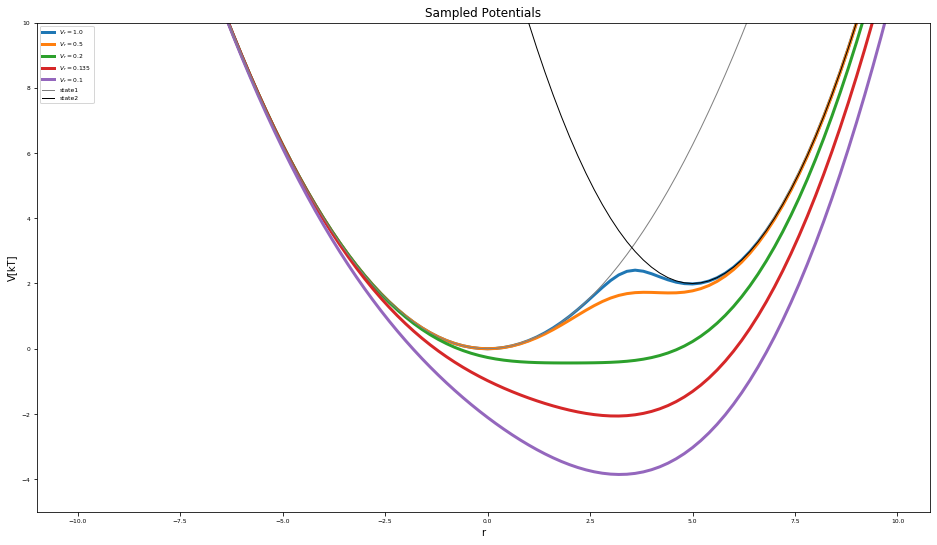

In [7]:
#Build Potential
s=1
Eoff = [0,2]
V_eds = pot.envelopedPotential(V_is=[h1,h2] , s=s)

s1 = 1.0
s2 = 0.5
s3 = 0.2
s4 = 0.135
s5 = 0.1

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

V_eds.s=s1
plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(s1)+"$")
V_eds.s=s2
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s2)+"$")
V_eds.s=s3
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s3)+"$")
V_eds.s=s4
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s4)+"$")
V_eds.s=s5
plt.plot(positions,V_eds.ene(positions), lw=3,  label="$V_r="+str(s5)+"$")


plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
#plt.xlim([-2,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [15]:
steps = simulation_steps_total_per_approach//10
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
eds_system = edsSystem(potential=V_eds, integrator=integrator, eds_Eoff=Eoff)

eds_system.set_s(s1)
eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
state1_traj = eds_system.getTrajectory()

eds_system.set_s(s2)
eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
state2_traj = eds_system.getTrajectory()

eds_system.set_s(s3)
eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
state3_traj = eds_system.getTrajectory()

eds_system.set_s(s4)
eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
state4_traj = eds_system.getTrajectory()

eds_system.set_s(s5)
eds_system.simulate(steps, withdrawTraj=True, initSystem=True)
state5_traj = eds_system.getTrajectory()

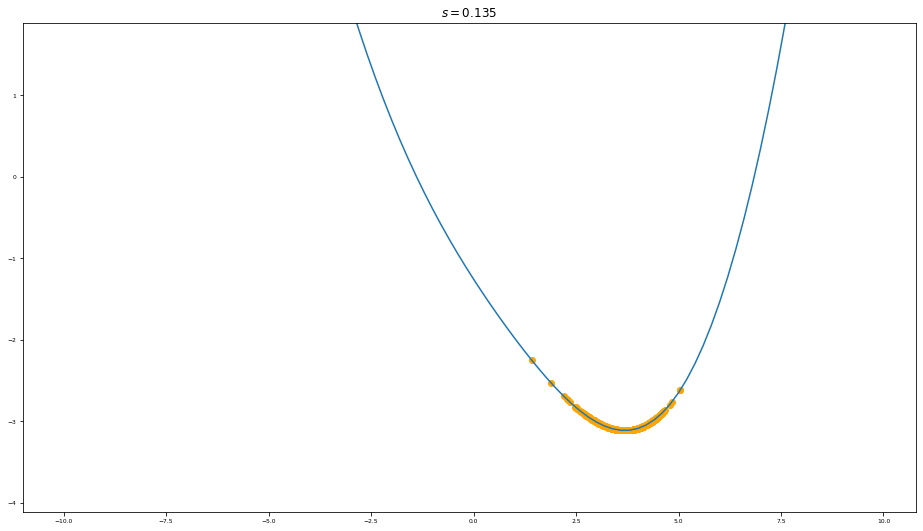

In [16]:
fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
V_eds.s_i = s4
ene =  V_eds.ene(positions)
axes[0].plot(positions, ene, c="C0", )
axes[0].scatter(list(state4_traj.position[equilibration_steps:]), state4_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[0].set_ylim([np.min(ene)-1,np.min(ene)+5])
axes[0].set_title("$s = "+str(state4_traj.s[1])+"$")

fig.savefig("EDS_sampling.png")

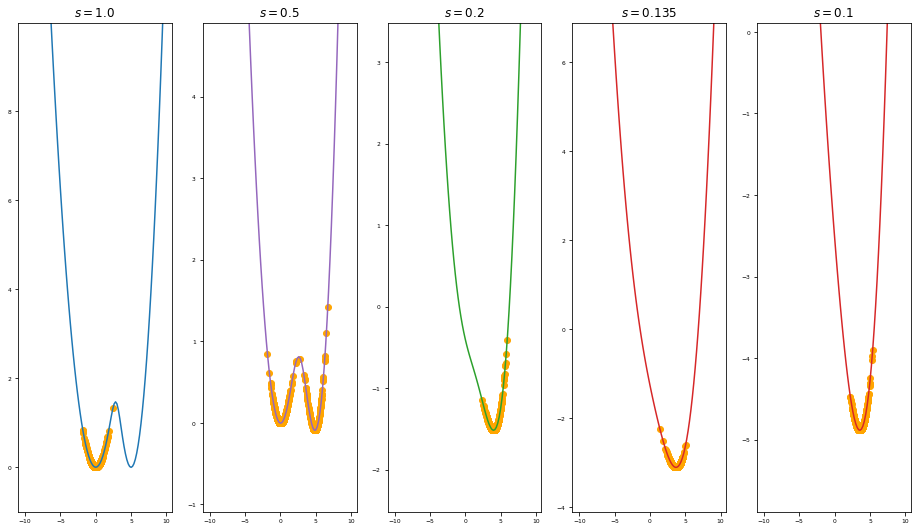

In [17]:
#Visualisation
fig, axes = plt.subplots(ncols=5, figsize=[16,9])

V_eds.s_i = s1
ene =  V_eds.ene(positions)
axes[0].plot(positions, ene, c="C0", )
axes[0].scatter(list(state1_traj.position[equilibration_steps:]), state1_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[0].set_ylim([np.min(ene)-1,np.min(ene)+10])
axes[0].set_title("$s = "+str(state1_traj.s[1])+"$")


V_eds.s = s2
ene =  V_eds.ene(positions)
axes[1].plot(positions, ene, c="C4", )
axes[1].scatter(list(state2_traj.position[equilibration_steps:]), state2_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[1].set_ylim([np.min(ene)-1,np.min(ene)+5])
axes[1].set_title("$s =  "+str(state2_traj.s[1])+"$")


V_eds.s = s3
ene = V_eds.ene(positions)
axes[2].plot(positions, V_eds.ene(positions), c="C2", )
axes[2].scatter(list(state3_traj.position[equilibration_steps:]), state3_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[2].set_ylim([np.min(ene)-1,np.min(ene)+5])
axes[2].set_title("$s =  "+str(state3_traj.s[1])+"$")


V_eds.s = s4
ene =  V_eds.ene(positions)
axes[3].plot(positions, ene, c="C3", )
axes[3].scatter(list(state4_traj.position[equilibration_steps:]), state4_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[3].set_ylim([np.min(ene)-1,np.min(ene)+10])
axes[3].set_title("$s =  "+str(state4_traj.s[1])+"$")

V_eds.s = s5
ene =  V_eds.ene(positions)
axes[4].plot(positions, ene, c="C3", )
axes[4].scatter(list(state5_traj.position[equilibration_steps:]), state5_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[4].set_ylim([np.min(ene)-1,np.min(ene)+5])
axes[4].set_title("$s =  "+str(state5_traj.s[1])+"$")
pass

### FEP-EDS_Evaluation

In [20]:
print("SIMULATION 1")
print("\ts = ", s1)
positions = state1_traj.position[equilibration_steps:]
Vr = list(map(float, state1_traj.totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)

rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 2")
print("\ts = ", s2)
positions = state2_traj.position[equilibration_steps:]
Vr = list(map(float, state2_traj.totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 3")
print("\ts = ", s3)
positions = state3_traj.position[equilibration_steps:]
Vr = list(map(float, state3_traj.totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")


print("SIMULATION 4")
print("\ts = ", s4)
positions = state4_traj.position[equilibration_steps:]
Vr = list(map(float, state4_traj.totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

print("SIMULATION 5")
print("\ts = ", s5)
positions = state5_traj.position[equilibration_steps:]
Vr = list(map(float, state5_traj.totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

SIMULATION 1
	s =  1.0

	Expected Result:  2.3465735902799727
	dF_Calc Result:  19.161734783724434

	Difference: 16.81516119344446




SIMULATION 2
	s =  0.5

	Expected Result:  2.3465735902799727
	dF_Calc Result:  12.59337567803139

	Difference: 10.246802087751416




SIMULATION 3
	s =  0.2

	Expected Result:  2.3465735902799727
	dF_Calc Result:  -1.917068942917643

	Difference: -4.263642533197616




SIMULATION 4
	s =  0.135

	Expected Result:  2.3465735902799727
	dF_Calc Result:  -0.4486899142584386

	Difference: -2.7952635045384113




SIMULATION 5
	s =  0.1

	Expected Result:  2.3465735902799727
	dF_Calc Result:  -0.29350477982575107

	Difference: -2.6400783701057238






### BAR-EDS_Evaluation

# Hybrid Methods - $\lambda-EDS $

Text(0.5, 1.0, 'Sampled Potentials')

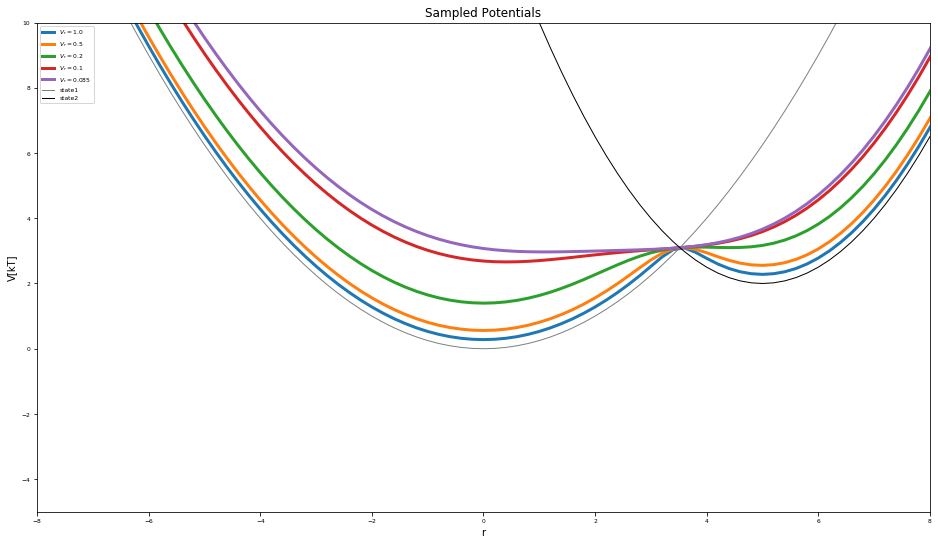

In [22]:
#Build Potential
s=1
V_hleds = pot.hybridCoupledPotentials(Va=h1, Vb=h2, s=s, lam=0.5)

s1 = 1.0
s2 = 0.5
s3 = 0.2
s4 = 0.1
s5 = 0.085

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

V_hleds.set_s(s1)
plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(s1)+"$")
V_hleds.set_s(s2)
plt.plot(positions,V_hleds.ene(positions), lw=3,  label="$V_r="+str(s2)+"$")
V_hleds.set_s(s3)
plt.plot(positions,V_hleds.ene(positions), lw=3,  label="$V_r="+str(s3)+"$")
V_hleds.set_s(s4)
plt.plot(positions,V_hleds.ene(positions), lw=3,  label="$V_r="+str(s4)+"$")
V_hleds.set_s(s5)
plt.plot(positions,V_hleds.ene(positions), lw=3,  label="$V_r="+str(s5)+"$")

V_hleds.set_s(s4)

plt.plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,h2.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

In [23]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)
hleds_system = edsSystem(potential=V_hleds, integrator=integrator, eds_s=s5)

hleds_system.simulate(steps, withdrawTraj=True, initSystem=True)
state_hle1_traj = hleds_system.getTrajectory()


0.085


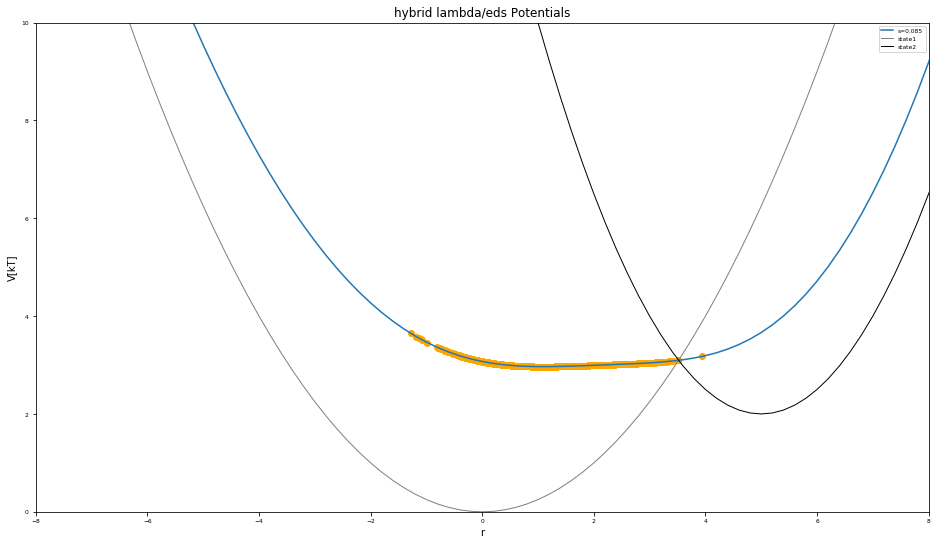

In [24]:
print(hleds_system.s)
positions = np.arange(-10,10, 0.2)

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
V_hleds.set_s(hleds_system.s)
ene =  V_hleds.ene(positions)
axes[0].plot(positions, ene, c="C0", label="s="+str(hleds_system.s))
axes[0].scatter(list(state_hle1_traj.position[equilibration_steps:]), state_hle1_traj.totPotEnergy[equilibration_steps:], c="orange")
axes[0].set_ylim([np.min(ene)-1,np.min(ene)+5])
axes[0].set_title("$s = "+str(state_hle1_traj.s[1])+"$")
axes[0].plot(positions,h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions,h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("hybrid lambda/eds Potentials")
fig.savefig("h_lambda_EDS_sampling.png")

In [25]:
print("SIMULATION 1")
print("\ts = ", hleds_system.s)
positions = state_hle1_traj.position[equilibration_steps:]
Vr = list(map(float, state_hle1_traj.totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)

rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

SIMULATION 1
	s =  0.085

	Expected Result:  2.3465735902799727
	dF_Calc Result:  13.017272432863404

	Difference: 10.67069884258343






# Enhanced Sampling with system Coupling

#### Conveyor Belt TI

In [26]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=h1, Vb=h2)
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

syst = perturbed_system.perturbedSystem(potential=V_perturbed , integrator=integrator)
ens=cvb.ConveyorBelt(0.0, numsys, system=syst, build=False)


In [27]:
ens.simulate(steps//numsys)


In [28]:
trajs = ens.get_trajectories()
trajs[0]

,position,temperature,totEnergy,totPotEnergy,totKinEnergy,dhdpos,velocity,lam,dhdlam
0,-1.29123,298.0,11.103297,11.103297,NaN,-3.46842,NaN,0.000000,21.372958
1,-1.0152533164725703,298.0,0.257685,0.257685,NaN,0.27597481819204195,NaN,0.000000,19.833951
2,-0.03840183781562401,298.0,0.000369,0.000369,NaN,0.9768514786569463,NaN,0.000000,14.692378
3,0.21436248985679163,298.0,0.021474,0.021474,NaN,0.25276432767241563,NaN,0.000743,13.439675
4,0.0564163025329909,298.0,0.011360,0.011360,NaN,-0.15794618732380072,NaN,0.000743,14.218714
...,...,...,...,...,...,...,...,...,...
4996,0.5916557904547105,298.0,1.971549,1.971549,NaN,-0.8035093872817461,NaN,0.162008,11.629235
4997,0.33561160338597196,298.0,0.046908,0.046908,NaN,-0.25604418706873855,NaN,0.001459,12.850101
4998,0.2299080729841939,298.0,0.032713,0.032713,NaN,-0.10570353040177805,NaN,0.001459,13.363674
4999,-0.17115064762150467,298.0,0.029739,0.029739,NaN,-0.4010587206056986,NaN,0.001459,15.363076


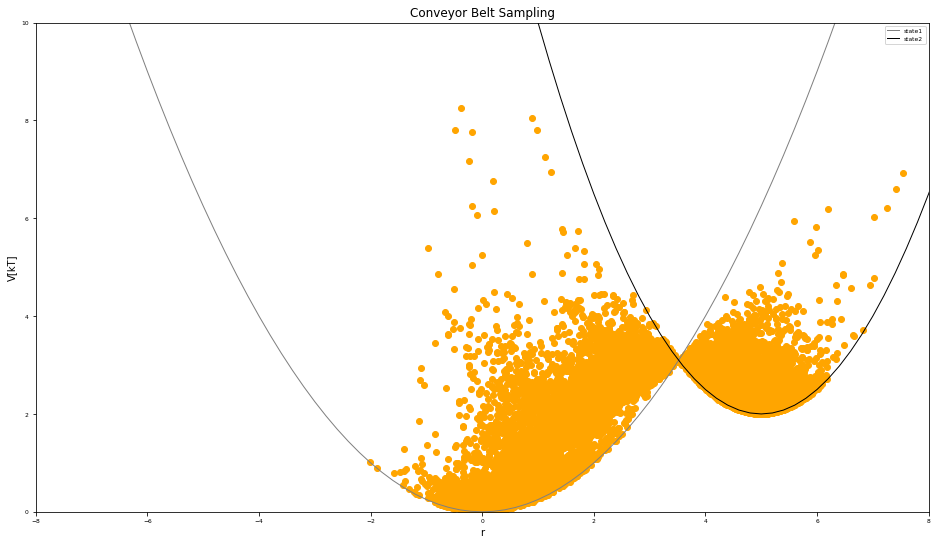

In [29]:
import pandas as pd
trajs = ens.get_trajectories()
mega_traj = pd.concat(list(trajs.values()), ignore_index=True)

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)


fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.totPotEnergy[equilibration_steps:], c="orange")

positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, h1.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, h2.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.png")

In [30]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]
lam_cvb = list(sorted(np.unique(lambda_stat.lam)))
means_cvb = [np.mean(lambda_stat.loc[lambda_stat.lam == x].dhdlam) for x in lam_cvb] 
stds_cvb = [np.std(lambda_stat.loc[lambda_stat.lam == x].dhdlam) for x in lam_cvb] 


In [31]:
dF_trapez = integrate.trapz(x=lam_cvb, y=means_cvb)
dF_err = integrate.trapz(x=lam_cvb, y=stds_cvb)

print()
print("Expected Result: ", dG_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dG_expected)



Expected Result:  2.3465735902799727
trapez Rule Result:  2.1289523097523375 +- 1.0204953115418418

Difference: -0.21762128052763519


# RE-EDS

In [32]:
#potential
Eoff = [0,1.5]
V_eds = pot.envelopedPotential(V_is=[h1,h2])

##Integrator
integrator = metropolisMonteCarloIntegrator(randomnessIncreaseFactor=rand)

##System
eds_system = edsSystem(integrator=integrator, potential=V_eds)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=4)
trials=200
steps_between_trials=simulation_steps_total_per_approach//(len(s_values)*trials)

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.ReplicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None, s_range=s_values, steps_between_trials=steps_between_trials)
[replica.s for repID, replica in ensemble.replicas.items()]


[0, 1.5]
DO trials:  200 steps:  12


[1.0, 0.4641588833612779, 0.2154434690031884, 0.1]

In [33]:
ensemble.simulate(trials, reset_ensemble=True)


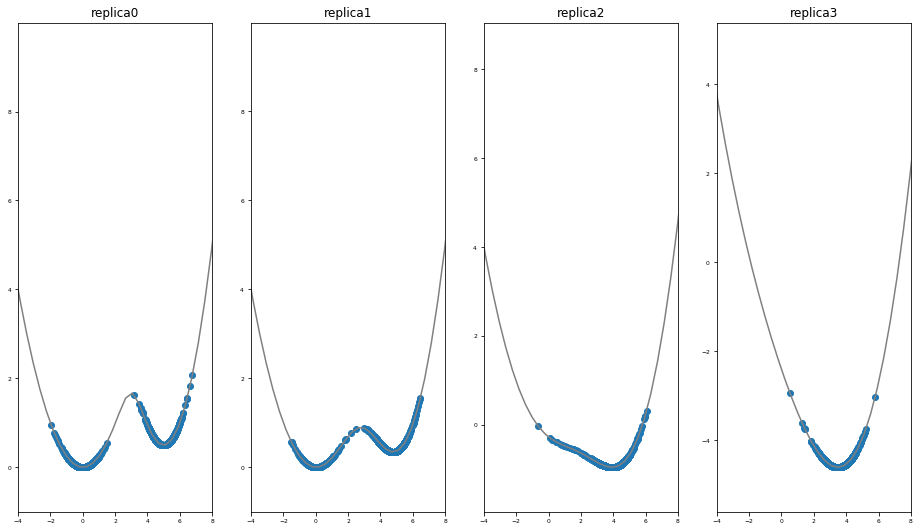

In [34]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey")
    min_e = np.min(trajs[traj].totEnergy[eqil:])

    ax.scatter(trajs[traj].position[eqil:], trajs[traj].totEnergy[eqil:])
    ax.set_ylim([min_e-1,min_e+10])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


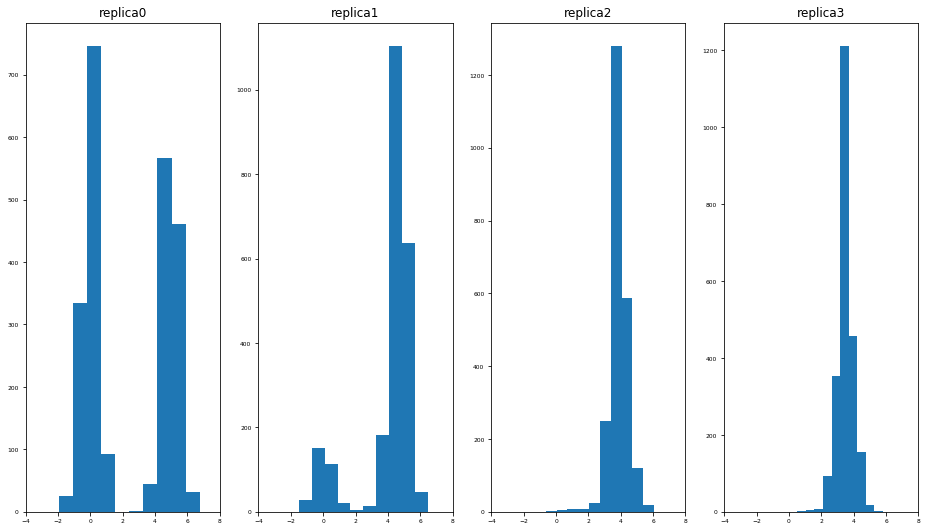

In [35]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(trajs, axes):
    ax.hist(trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


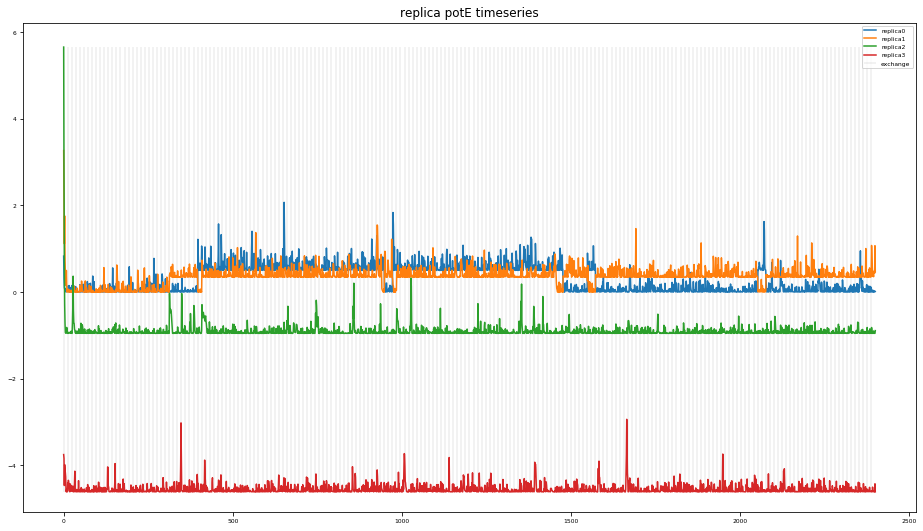

In [36]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [trajs[x].totEnergy for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

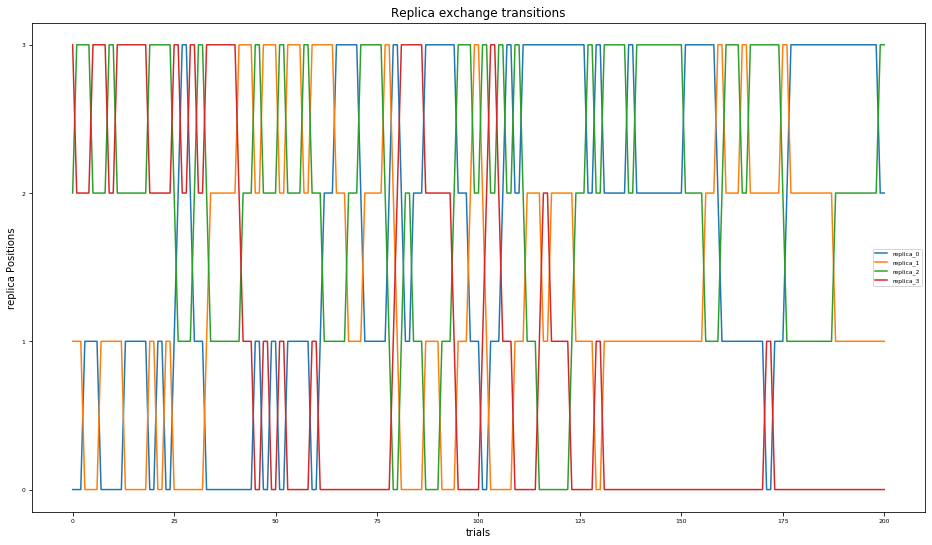

In [37]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [38]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 0")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[0].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

Reeds Rep 0
	s =  1.0

	Expected Result:  2.3465735902799727
	dF_Calc Result:  12.81872994809753

	Difference: 10.472156357817557






In [39]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 0")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[1].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

Reeds Rep 0
	s =  1.0

	Expected Result:  2.3465735902799727
	dF_Calc Result:  10.685674034590424

	Difference: 8.33910044431045






In [40]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 3")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[2].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

Reeds Rep 3
	s =  1.0

	Expected Result:  2.3465735902799727
	dF_Calc Result:  5.907921859630497

	Difference: 3.5613482693505247






In [41]:
#FREE E
equilibration_steps=100

#State Potentials
h1 = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
h2 = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

print("Reeds Rep 4")
print("\ts = ", ensemble.exchange_dimensions['s'][0])
positions = trajs[3].position[equilibration_steps:]
Vr = list(map(float, trajs[0].totEnergy[equilibration_steps:]))
V1 = h1.ene(positions)
V2 = h2.ene(positions)


rew_zwanz = threeStateZwanzigReweighting(kT=True)
dFRew_zwanz = rew_zwanz.calculate(Vi=V2, Vj=V1, Vr=Vr)

print()
print("\tExpected Result: ", dG_expected)
print("\tdF_Calc Result: ", dFRew_zwanz)
print()
print("\tDifference:", dFRew_zwanz - dG_expected)
print("\n\n\n")

Reeds Rep 4
	s =  1.0

	Expected Result:  2.3465735902799727
	dF_Calc Result:  1.3403339134379726

	Difference: -1.006239676842




